# Setup

#### Imports

In [1]:
import pathlib

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import polars as pl

#### Print library versions

In [2]:
print(f'{pd.__version__ = }')
print(f'{pl.__version__ = }')

pd.__version__ = '2.2.2'
pl.__version__ = '1.0.0'


# Questions

- Q1: What percent of titles are movies vs shows?
- Q2: What has been the trend in movie/show releases by year?
- Q3: Who are the five cast members associated with the most unique titles?
- Q4: Who are the five cast members associated with the most unique categories?

**For all questions, only consider the data for titles released during or after 1990**

#### Define data filepath

In [3]:
data_filepath = pathlib.Path('netflix_titles.csv')

## Q1 - What percent of titles are movies vs shows?

#### `pandas` implementation

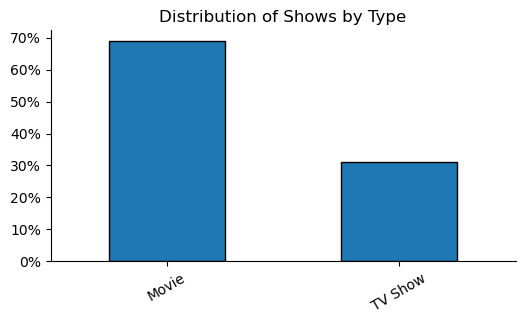

CPU times: user 96.8 ms, sys: 15 ms, total: 112 ms
Wall time: 113 ms


In [4]:
%%time

data = pd.read_csv(
    data_filepath
)
year_filter = data['release_year'] >= 1990

show_types = data[year_filter].groupby(
    ['type']
).agg(
    unique_ids = ('show_id', 'nunique')
)

show_types['unique_ids'] = show_types['unique_ids']/show_types['unique_ids'].sum()

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

show_types.plot(
    kind='bar',
    edgecolor='k',
    legend=False,
    ax=ax,
)
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(
    axis='x',
    labelrotation=30,
)
ax.set_xlabel('')
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
ax.set_title('Distribution of Shows by Type')

plt.show()

#### `polars` implementation

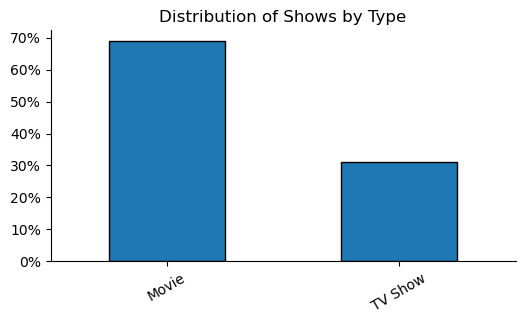

CPU times: user 95.5 ms, sys: 18.7 ms, total: 114 ms
Wall time: 98.7 ms


In [5]:
%%time

show_types = pl.read_csv(
    data_filepath
).filter(
    pl.col('release_year') >= 1990
).group_by(
    pl.col('type')
).agg(
    unique_ids = pl.col('show_id').n_unique()
).with_columns(
    pl.col('unique_ids')/pl.col('unique_ids').sum()
)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

show_types.to_pandas().set_index('type').plot(
    kind='bar',
    edgecolor='k',
    legend=False,
    ax=ax,
)
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(
    axis='x',
    labelrotation=30,
)
ax.set_xlabel('')
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
ax.set_title('Distribution of Shows by Type')

plt.show()

## Q2: What has been the trend in movie/show releases by year?

#### `pandas` implementation

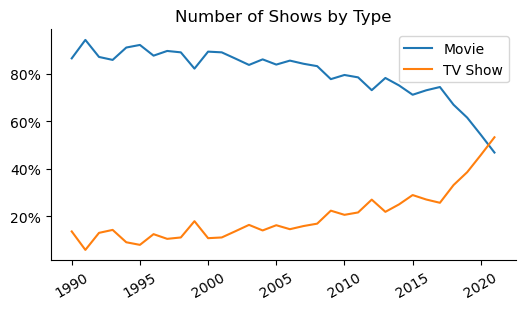

CPU times: user 93.6 ms, sys: 11 ms, total: 105 ms
Wall time: 104 ms


In [6]:
%%time

data = pd.read_csv(
    data_filepath
)
year_filter = data['release_year'] >= 1990

shows_by_type_and_year = data[year_filter].groupby(
    ['type', 'release_year']
).agg(
    unique_ids = ('show_id', 'nunique')
).reset_index().pivot(
    index='release_year',
    columns='type',
).fillna(0)

shows_by_type_and_year.columns = [val[1] for val in shows_by_type_and_year.columns]

year_sums = shows_by_type_and_year.sum(axis=1)

shows_by_type_and_year['Movie'] = shows_by_type_and_year['Movie']/year_sums
shows_by_type_and_year['TV Show'] = shows_by_type_and_year['TV Show']/year_sums

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

shows_by_type_and_year.plot(
    kind='line',
    ax=ax,
)
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(
    axis='x',
    labelrotation=30,
)
ax.set_xlabel('')
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
ax.set_title('Number of Shows by Type')

plt.show()

#### `polars` implementation

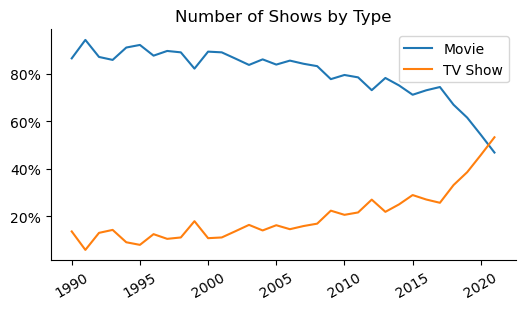

CPU times: user 82.8 ms, sys: 10 ms, total: 92.8 ms
Wall time: 76.8 ms


In [7]:
%%time

data = pl.read_csv(
    data_filepath
).filter(
    pl.col('release_year') >= 1990
).group_by(
    ['type', 'release_year']
).agg(
    unique_ids = pl.col('show_id').n_unique()
).pivot(
    index='release_year',
    on='type',
).fill_null(0).with_columns(
    pl.all().exclude('release_year')/pl.sum_horizontal(pl.all().exclude('release_year'))
).sort(
    'release_year'
)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

data.to_pandas().set_index('release_year').plot(
    kind='line',
    ax=ax,
)
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(
    axis='x',
    labelrotation=30,
)
ax.set_xlabel('')
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
ax.set_title('Number of Shows by Type')

plt.show()

## Q3: Who are the five cast members associated with the most unique titles?

#### `pandas` implementation

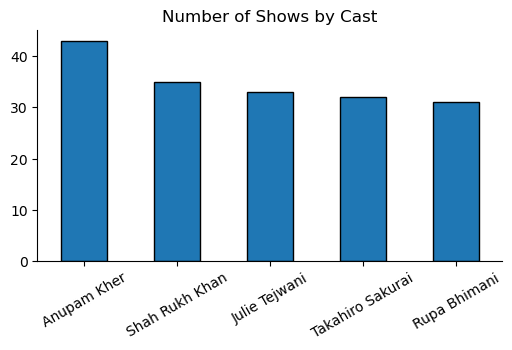

CPU times: user 109 ms, sys: 6.98 ms, total: 116 ms
Wall time: 116 ms


In [8]:
%%time

data = pd.read_csv(
    data_filepath,
    usecols=['release_year', 'cast', 'show_id'],
)
year_filter = data['release_year'] >= 1990
data = data[year_filter]

data['cast'] = data['cast'].str.split(',')
data = data.explode('cast')
data['cast'] = data['cast'].str.strip()

top_cast_by_ids = data.groupby(
    ['cast']
).agg(
    unique_shows = ('show_id', 'nunique')
).nlargest(
    n=5, 
    columns='unique_shows',
)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

top_cast_by_ids.plot(
    kind='bar',
    ax=ax,
    edgecolor='k',
    legend=False,
)
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(
    axis='x',
    labelrotation=30,
)
ax.set_xlabel('')
ax.set_title('Number of Shows by Cast')

plt.show()

#### `polars` implementation

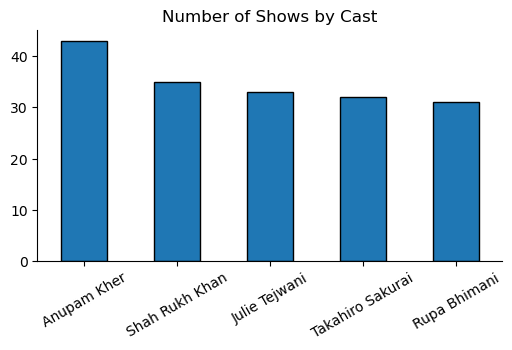

CPU times: user 161 ms, sys: 18.3 ms, total: 179 ms
Wall time: 74.3 ms


In [9]:
%%time

top_cast_by_ids = pl.read_csv(
    data_filepath,
    columns=['release_year', 'cast', 'show_id']
).filter(
    pl.col('release_year') >= 1990
).with_columns(
    pl.col('cast').str.split(',')
).explode(
    'cast'
).with_columns(
    pl.col('cast').str.strip_chars()
).group_by(
    ['cast']
).agg(
    unique_shows = pl.col('show_id').n_unique()
).drop_nulls(
    'cast'
).top_k(
    k=5, 
    by='unique_shows',
)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

top_cast_by_ids.to_pandas().set_index('cast').plot(
    kind='bar',
    ax=ax,
    edgecolor='k',
    legend=False,
)
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(
    axis='x',
    labelrotation=30,
)
ax.set_xlabel('')
ax.set_title('Number of Shows by Cast')

plt.show()

## Q4: Who are the five cast members associated with the most unique categories?

#### `pandas` implementation

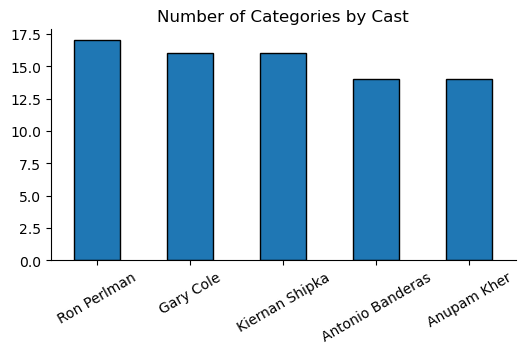

CPU times: user 148 ms, sys: 17.9 ms, total: 166 ms
Wall time: 165 ms


In [10]:
%%time

data = pd.read_csv(
    data_filepath,
    usecols=['release_year', 'cast', 'listed_in'],
)
year_filter = data['release_year'] >= 1990
data = data[year_filter]

data['listed_in'] = data['listed_in'].str.split(',')
data = data.explode('listed_in')
data['listed_in'] = data['listed_in'].str.strip()

data['cast'] = data['cast'].str.split(',')
data = data.explode('cast')
data['cast'] = data['cast'].str.strip()

top_cast_by_categories = data.groupby(
    ['cast']
).agg(
    unique_categories = ('listed_in', 'nunique')
).nlargest(
    n=5, 
    columns='unique_categories',
)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

top_cast_by_categories.plot(
    kind='bar',
    ax=ax,
    edgecolor='k',
    legend=False,
)
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(
    axis='x',
    labelrotation=30,
)
ax.set_xlabel('')
ax.set_title('Number of Categories by Cast')

plt.show()

#### `polars` implementation

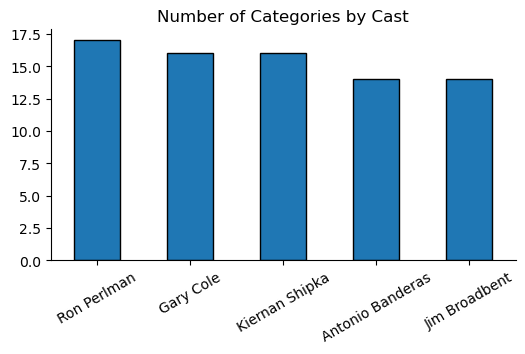

CPU times: user 167 ms, sys: 16.5 ms, total: 184 ms
Wall time: 89.1 ms


In [11]:
%%time

top_cast_by_categories = pl.read_csv(
    data_filepath,
    columns=['release_year', 'cast', 'listed_in'],
).filter(
    pl.col('release_year') >= 1990
).with_columns(
    pl.col('listed_in').str.split(',')
).explode(
    pl.col('listed_in')
).with_columns(
    pl.col('listed_in').str.strip_chars()
).with_columns(
    pl.col('cast').str.split(',')
).explode(
    pl.col('cast')
).with_columns(
    pl.col('cast').str.strip_chars()
).group_by(
    ['cast']
).agg(
    unique_categories = pl.col('listed_in').n_unique()
).drop_nulls(
    'cast'
).top_k(
    k=5, 
    by='unique_categories',
)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

top_cast_by_categories.to_pandas().set_index('cast').plot(
    kind='bar',
    ax=ax,
    edgecolor='k',
    legend=False,
)
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(
    axis='x',
    labelrotation=30,
)
ax.set_xlabel('')
ax.set_title('Number of Categories by Cast')

plt.show()